<a href="https://colab.research.google.com/github/mkozlik/MIDS-GNN/blob/main/MIDS_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import and install


In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 28.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [31]:
import random
from pathlib import Path

import matplotlib
import networkx as nx
import torch
import torch_geometric.utils as pygUtils
import Utilities.utils as utils
import yaml
from matplotlib import pyplot as plt
from torch_geometric.data import InMemoryDataset, download_url, extract_zip
from tqdm import tqdm


raw_download_url = "https://github.com/mkrizmancic/MIDS_collection/raw/master/PyTorch%20Geometric/Dataset/raw_data.zip"


class MIDSdataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, **kwargs):
        self.raw_included_subdirs = kwargs.get("raw_included_subdirs", None)

        super().__init__(root, transform, pre_transform, pre_filter)

        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        """
        Return a list of all raw files in the dataset.

        This method has two jobs. The returned list with raw files is compared
        with the files currently in raw directory. Files that are missing are
        automatically downloaded using download method. The second job is to
        return the list of raw file names that will be used in the process
        method.
        """
        raw_dir = Path(self.raw_dir)
        raw_files = []
        with open(raw_dir.parent / "file_list.yaml", "r") as file:
            raw_dir_structure = yaml.safe_load(file)
            for subdir in raw_dir_structure:
                if self.raw_included_subdirs is None or subdir in self.raw_included_subdirs:
                    raw_files.extend([f"{subdir}/{filename}" for filename in raw_dir_structure[subdir]])

        return raw_files

    @property
    def processed_file_names(self):
        """
        Return a list of all processed files in the dataset.

        If a processed file is missing, it will be automatically created using
        the process method.

        That means that if you want to reprocess the data, you need to delete
        the processed files and reimport the dataset.
        """
        # TODO: Automatically detect changes in the dataset.
        #       We could come up with a namig scheme that will differentiate
        #       which graph families (and/or sizes) and features were used to
        #       generate the dataset. This way, we could detect changes and
        #       reprocess the dataset when needed.
        return ["data.pt"]

    def download(self):
        """Automatically download raw files if missing."""
        # TODO: Should check and download only missing files.

        zip_file = Path(self.root) / "raw_data.zip"

        # Delete the exising zip file.
        zip_file.unlink(missing_ok=True)

        # Download the raw files using the helper function.
        download_url(raw_download_url, self.root, filename="raw_data.zip")

        # Unzip the downloaded files.
        extract_zip(str(zip_file.resolve()), self.raw_dir)

    def process(self):
        """Process the raw files into a graph dataset."""
        # Read data into huge `Data` list.
        data_list = []
        with tqdm(total=len(self.raw_file_names)) as pbar:
            for graph_file in self.raw_file_names:
                data = self.make_data(Path(self.raw_dir) / graph_file)
                data_list.extend(data)
                pbar.update(1)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def make_data(self, graph_file):
        """Create a PyG data object from a graph file."""
        G = nx.read_edgelist(graph_file, nodetype=int)

        # Define features in use.
        feature_functions = {
            "degree": G.degree,
            "degree_centrality": nx.degree_centrality(G),
            "betweenness_centrality": nx.betweenness_centrality(G)
        }

        # Compute and add features to the nodes in the graph.
        for node in G.nodes():
            for feature in feature_functions:
                G.nodes[node][feature] = feature_functions[feature][node]

        # for node in G.nodes():
        #     G.nodes[node]["degree"] = G.degree(node)

        # degree_cent = nx.degree_centrality(G)
        # for node in G.nodes():
        #     G.nodes[node]["degree_centrality"] = degree_cent[node]

        # between_cent = nx.betweenness_centrality(G)
        # for node in G.nodes():
        #     G.nodes[node]["betweenness_centrality"] = between_cent[node]

        torch_G = pygUtils.from_networkx(G, group_node_attrs=list(feature_functions.keys()))
        true_labels = MIDSdataset.get_labels(utils.find_MIDS(G), G.number_of_nodes())
        data = []
        for labels in true_labels:
            data.append(torch_G.clone())
            data[-1].y = labels

        return data

    @staticmethod
    def get_labels(mids, num_nodes):
        # Encode found cliques as support vectors.
        for i, nodes in enumerate(mids):
            mids[i] = torch.zeros(num_nodes)
            mids[i][nodes] = 1

        return mids

    @staticmethod
    def visualize_data(data):
        G = pygUtils.to_networkx(data, to_undirected=True)
        nx.draw(G, with_labels=True, node_color=data.y, cmap=matplotlib.colormaps["bwr"])
        plt.show()


def inspect_dataset(dataset, num_graphs=1):
    for i in random.sample(range(len(dataset)), num_graphs):
        data = dataset[i]  # Get a random graph object

        print()
        print(data)
        print("=============================================================")

        # Gather some statistics about the first graph.
        print(f"Number of nodes: {data.num_nodes}")
        print(f"Number of edges: {data.num_edges}")
        print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
        print(f"Has isolated nodes: {data.has_isolated_nodes()}")
        print(f"Has self-loops: {data.has_self_loops()}")
        print(f"Is undirected: {data.is_undirected()}")

        MIDSdataset.visualize_data(data)


def main():
    root = Path.cwd() / "Dataset"
    raw_included_subdirs = None

    dataset = MIDSdataset(root, raw_included_subdirs=raw_included_subdirs)

    print()
    print(f"Dataset: {dataset}:")
    print("====================")
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {dataset.num_classes}")

    inspect_dataset(dataset, num_graphs=1)


if __name__ == "__main__":
    main()



Dataset: MIDSdataset(40591):
Number of graphs: 40591
Number of features: 3
Number of classes: 2

Data(edge_index=[2, 30], x=[8, 3], y=[8])
Number of nodes: 8
Number of edges: 30
Average node degree: 3.75
Has isolated nodes: False
Has self-loops: False
Is undirected: True


AttributeError: 'GlobalStorage' object has no attribute 'train_mask'

Load dataset

In [4]:
root = Path.cwd() / "Dataset"
raw_included_subdirs = None

dataset = MIDSdataset(root, raw_included_subdirs=raw_included_subdirs)

print()
print(f"Dataset: {dataset}:")
print("====================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")


Dataset: MIDSdataset(40591):
Number of graphs: 40591
Number of features: 3
Number of classes: 2



Data(edge_index=[2, 14], x=[8, 3], y=[8])
Number of nodes: 8
Number of edges: 14
Average node degree: 1.75
Has isolated nodes: False
Has self-loops: False
Is undirected: True


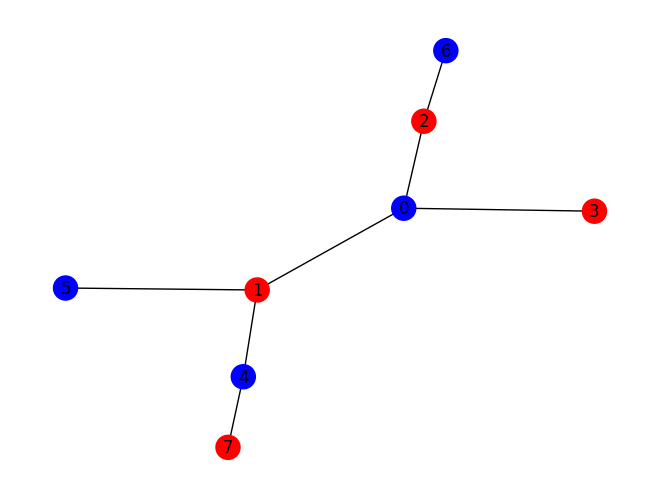

In [15]:
inspect_dataset(dataset, num_graphs=1)

Split into test and train

In [16]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:35000]
test_dataset = dataset[35000:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 35000
Number of test graphs: 5591


In [63]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Copy/paste GCN

In [64]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        #x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

model = GCN(hidden_channels=128)
print(model)

GCN(
  (conv1): GCNConv(3, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
import numpy as np

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()

      for i, data in enumerate(train_loader):
        #if i%100 !=0:
        #  continue
        out = model(data.x, data.edge_index)  # Perform a single forward pass.
        #print(data.y)
        #print(out)
        #print(data.x)
        #a = np.ones((data.x.size(dim=0),2))
        #print(a)
        #t = torch.from_numpy(a)
        #t = t.type(torch.bool)
        #train_mask = torch.tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=torch.bool)
        loss = criterion(out, data.y.type(torch.LongTensor))  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
      model.eval()
      correct = 0
      for data in loader:
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        #a = np.ones(data.x.size(dim=1))
        #train_mask = torch.tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=torch.bool)
        test_correct = pred == data.y  # Check against ground-truth labels.
        correct += int(torch.equal(pred,data.y))  # Derive ratio of correct predictions.
      return correct/len(loader.dataset)*100


for epoch in range(1, 101):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.0200, Test Acc: 0.0000
Epoch: 002, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 003, Train Acc: 0.0371, Test Acc: 0.0179
Epoch: 004, Train Acc: 0.0371, Test Acc: 0.0000
Epoch: 005, Train Acc: 0.0057, Test Acc: 0.0000
Epoch: 006, Train Acc: 0.3600, Test Acc: 0.3041
Epoch: 007, Train Acc: 0.0229, Test Acc: 0.0179
Epoch: 008, Train Acc: 1.6457, Test Acc: 1.3593
Epoch: 009, Train Acc: 0.0114, Test Acc: 0.0000
Epoch: 010, Train Acc: 0.0743, Test Acc: 0.0537
Epoch: 011, Train Acc: 0.0057, Test Acc: 0.0000
Epoch: 012, Train Acc: 0.0314, Test Acc: 0.0179
Epoch: 013, Train Acc: 0.0029, Test Acc: 0.0000
Epoch: 014, Train Acc: 0.0086, Test Acc: 0.0000
Epoch: 015, Train Acc: 0.2200, Test Acc: 0.1789
Epoch: 016, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 017, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 018, Train Acc: 0.0171, Test Acc: 0.0000
Epoch: 019, Train Acc: 0.4943, Test Acc: 0.4471
Epoch: 020, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 021, Train Acc: 0.4029, Test Acc: